In [1]:
from shared.preface import *
import shared.functions as fct
import shared.my_units as my
import shared.control_center as CC

## Using all-covering velocity range

In [2]:
_, upp = fct.velocity_limits_of_m_nu(CC.LOWER, CC.UPPER, 0.01*unit.eV, 'km/s')
low, _ = fct.velocity_limits_of_m_nu(CC.LOWER, CC.UPPER, 0.3*unit.eV, 'km/s')
print(low, upp)

v_kms = np.geomspace(low.value, upp.value, CC.Vs)

masses_eV = np.array([0.01,0.05,0.1,0.3])*unit.eV

for m in masses_eV:
    l, u = fct.velocity_limits_of_m_nu(CC.LOWER, CC.UPPER, m, 'km/s')
    select = np.where((l.value <= v_kms) & (v_kms <= u.value))[0]
    print(select.shape)

1.67921748804138 km / s 503765.246412414 km / s
(73,)
(72,)
(72,)
(73,)


## Convert from momentum to velocity limits and back

In [3]:
masses_eV = np.array([0.01,0.05,0.1,0.3])*unit.eV
masses_kg = masses_eV.to(unit.kg, unit.mass_energy())
for m_kg, m_eV in zip(masses_kg, masses_eV):

    ### Convert forwards

    # Conversion factor for limits.
    cf = my.T_nu_eV.to(unit.J) / m_kg / const.c

    # Limits on velocity.
    lower = CC.LOWER * cf.to(my.Uunit)
    upper = CC.UPPER * cf.to(my.Uunit)

    Uunit = unit.km/unit.s
    km_low, km_up = lower.to(Uunit), upper.to(Uunit) 
    print(km_low, km_up)


    ### Convert backwards

    p_low, y_low = fct.u_to_p_eV(lower.value, m_eV)
    p_upp, y_upp = fct.u_to_p_eV(upper.value, m_eV)

    print(np.round(y_low, 4), np.round(y_upp, 1))

50.37652464124141 km / s 503765.2464124141 km / s
0.01 100.0
10.075304928248277 km / s 100753.04928248277 km / s
0.01 100.0
5.037652464124139 km / s 50376.52464124138 km / s
0.01 100.0
1.6792174880413802 km / s 16792.1748804138 km / s
0.01 100.0


3.3333333333333335 eV 0.03333333333333333 eV 333.33333333333337 eV
(10000, 300) (10000, 300)
0.03333333333333333 333.3333333333334
0.03333333333333333 333.3333333333334


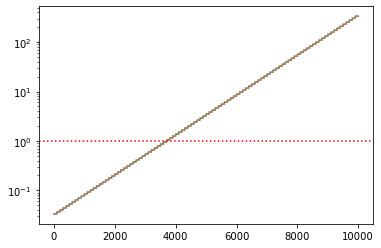

In [4]:
masses_eV = np.array([0.01,0.05,0.1,0.3])*unit.eV

u_all = fct.load_u_sim()

choice = masses_eV[2]
ratio = choice/CC.NU_MASS.value
print(ratio, ratio*CC.LOWER, ratio*CC.UPPER)
p, y = fct.u_to_p_eV(u_all, choice)
x = np.arange(CC.NR_OF_NEUTRINOS)
print(p.shape, y.shape)
all_p0 = p[:,0]
ind = all_p0.argsort()
all_p0_sort = all_p0[ind]

y0 = y[:,0][ind]
y1 = y[:,-1][ind]
print(y0[0], y0[-1])
print(y1[0], y1[-1])

plt.semilogy(x, y0)
plt.semilogy(x, y1, alpha=0.6)
plt.axhline(1e0, c='r', ls=':')
# plt.axhline(3.15, c='r', ls='-')
plt.show()


# print(all_p0_sort.shape)
# plt.semilogy(x,all_p0_sort)
# plt.show()

In [5]:
zeds = CC.ZEDS
print(len(zeds))
ss = np.array([fct.s_of_z(z) for z in zeds])# * my.H0.to(unit.s**-1).value

s_new = (ss[0] + ss[1])/2

f = interp1d(ss, zeds, kind='linear', assume_sorted=True)

z_new = f(s_new)
if zeds[0] < z_new < zeds[1]:
    print(z_new)


300
0.005025125628140704


## Manual conversion factor or grav_pot function.

In [6]:
units_raw = 1*const.G.unit * 1*my.rho0_NFW.unit * (1*unit.kpc)**2
units_goal = units_raw.to(unit.m**2/unit.s**2)

print(units_raw)
print(units_goal)

1.0 m3 solMass / (kg kpc s2)
64439975278.84992 m2 / s2


## Sorting logic for ndim arrays

In [7]:
x = np.array([[4, 6, 5], [2, 1, 0], [1,6,5]])
y = np.array([[0, 1, 5], [2, 4, 0], [7,6,5]])

ind = x[:, 0].argsort()

x_sort = x[ind]
y_sort = y[ind]

print(x_sort)
print(y_sort)



[[1 6 5]
 [2 1 0]
 [4 6 5]]
[[7 6 5]
 [2 4 0]
 [0 1 5]]


# Various tests on individual functions

## Number integral

In [8]:
FDarr = np.array([0.3,0.4,0.1,0.01])
p_arr = np.array([0.2, 0.1, 5., 8.]) * my.T_nu_eV.value

order = p_arr.argsort()
p_sort, FD_sort = p_arr[order], FDarr[order]
# print(p_sort, FD_sort)

n_int = np.trapz(p_sort**2 * FD_sort, p_sort)
print(n_int)

n_sum = np.sum(p_sort**2 * FD_sort)
print(n_sum)

5.0957792630544584e-11
8.911524289289443e-08


## Integral for cosmic time

In [9]:
def t_integrand_a(a):

    # original H0 in units ~[1/s], we only need the value
    H0 = my.H0.to(unit.s**-1).value

    a_dot = np.sqrt(my.Omega_m0/a**3 + my.Omega_L0)*H0*a
    t_int = 1/a_dot

    return t_int

t, err = quad(t_integrand_a, 0, 1)
t_uni, err_uni = (t*unit.s).to(unit.Gyr), (err*unit.s).to(unit.Gyr)
print(t_uni, err_uni)

13.79150102640378 Gyr 2.0300656577179505e-12 Gyr


In [10]:
def t_integrand_z(z):

    # original H0 in units ~[1/s], we only need the value
    H0 = my.H0.to(unit.s**-1).value

    a_dot = np.sqrt(my.Omega_m0*(1+z)**3 + my.Omega_L0)*H0*(1+z)
    t_int = 1/a_dot

    return t_int

t, err = quad(t_integrand_z, 0, np.inf)
t_uni, err_uni = (t*unit.s).to(unit.Gyr), (err*unit.s).to(unit.Gyr)
print(t_uni, err_uni)

13.791501026403786 Gyr 3.86300605876239e-11 Gyr


## Initial velocity limits

In [11]:
m_sim_eV = 0.05*unit.eV
low_kpc, upp_kpc = fct.velocity_limits_of_m_nu(0.01, 10., m_sim_eV, mode='kpc/s')
print(low_kpc,upp_kpc)

m_sim_eV = 0.05*unit.eV
low_km, upp_km = fct.velocity_limits_of_m_nu(0.01, 10., m_sim_eV, mode='km/s')
print(low_km,upp_km)

3.265183954630376e-16 kpc / s 3.265183954630376e-13 kpc / s
10.075304928248277 km / s 10075.304928248277 km / s


## Simulated velocities in [kpc/s] to momenta in [eV] for any (neutrino) mass

In [12]:
u_sim = np.load(f'neutrino_vectors/nu_2.npy')[-1,3:6]
m_sim_eV = 0.05*unit.eV
m_target_eV = 0.05*unit.eV

# p, y = fct.u_to_p_eV(u_sim, m_sim_eV, m_target_eV)
# print(p, y)

## 1/hc to cm^-1/eV

In [13]:
hc_neg1 = (1/const.h/const.c).to(1/unit.cm/unit.eV)
print(hc_neg1)

n_cm3 = 1*unit.eV**3 * hc_neg1**3
print(n_cm3)

8065.543937349209 1 / (cm eV)
524687821733.6669 1 / cm3


## Beta factor

In [14]:
def c_vir_avg(z, M_vir):
    # Functions from Mertsch et al. (2020), eqns. (12) and (13) in ref. [40].
    a_of_z = 0.537 + (0.488)*np.exp(-0.718*np.power(z, 1.08))
    b_of_z = -0.097 + 0.024*z

    # Argument in log has to be dimensionless
    arg_in_log = (M_vir / (1.e12 / my.h * unit.M_sun)).value

    # Calculate avergae c_vir
    c_vir_avg = np.power(a_of_z + b_of_z*np.log10(arg_in_log), 10.)

    return c_vir_avg

# Beta is then obtained from c_vir_avg(0, M_vir) and c_vir(0, M_vir).
beta = (333.5/19.9) / c_vir_avg(0, my.Mvir_NFW)
print(beta)

14.928729169804287


## Table 1

In [15]:
# Tests for c_vir and the beta coefficient

cis = fct.c_vir(0, my.Mvir_NFW)
cis1 = fct.c_vir(4, my.Mvir_NFW)
print(cis, cis1)

16.758793969849247 0.04258828167400367


In [16]:
z_test = 4
print('R_vir:', fct.R_vir(z_test, my.Mvir_NFW))
print('scale_radius:', fct.scale_radius(z_test, my.Mvir_NFW))

R_vir: 81.78036756845792
scale_radius: 1920.255158319231


## Critical Density

In [17]:
crit = fct.rho_crit(0)
print('Check if this matches critical density of universe today:')
print(crit)

Check if this matches critical density of universe today:
127.05281539749838


## Unit Conversion Tests

In [18]:
print(my.T_nu.to(unit.eV, unit.temperature_energy()))

0.00016803799861183098 eV


## Derivative vector values

In [19]:
z = 0
x_i = np.array([8.5,0.,0.])*unit.kpc

t2 = fct.dPsi_dxi_NFW(x_i, z, my.rho0_NFW, my.Mvir_NFW)
print(type(t2), t2)

<class 'numpy.ndarray'> [3.70279628e-30 0.00000000e+00 0.00000000e+00]


## Time Variable s

In [20]:
H0_mod = my.H0.to(unit.s**-1.).value
print(H0_mod)

2.192711267238057e-18


In [21]:
s = fct.s_of_z(4)
print('Value of time variable s in seconds at redhshift 4','\n', s)

h_s = my.H0.to(1/unit.s)
print('Age of universe in seconds:','\n', 1/h_s)

Value of time variable s in seconds at redhshift 4 
 1.7989872714122294e+18
Age of universe in seconds: 
 4.560563969097499e+17 s


In [22]:
s = fct.s_of_z(4)
print('Value of time variable s in seconds at redhshift 4','\n', s)

h_s = my.H0.to(1/unit.s)
print('Age of universe in seconds:','\n', 1/h_s)

Value of time variable s in seconds at redhshift 4 
 1.7989872714122294e+18
Age of universe in seconds: 
 4.560563969097499e+17 s


## Initial Velocities

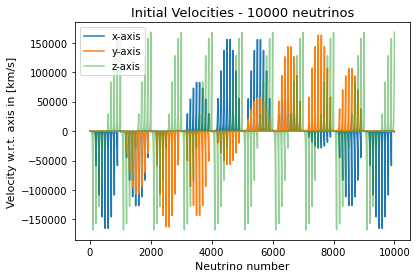

In [23]:
from backtracing_numba import draw_ui

# Draw initial velocities.
ui = draw_ui(CC.PHIs, CC.THETAs, CC.Vs)*my.Uunit
ui = ui.to(unit.km/unit.s).value

ux = ui[:,0]
uy = ui[:,1]
uz = ui[:,2]

x = np.arange(len(ux))
y = np.arange(len(uy))
z = np.arange(len(uz))

plt.plot(x, ux, label='x-axis', )
plt.plot(y, uy, label='y-axis', )
plt.plot(z, uz, label='z-axis', alpha=0.5)
plt.title(f'Initial Velocities - {CC.NR_OF_NEUTRINOS} neutrinos')
plt.xlabel('Neutrino number')
plt.ylabel('Velocity w.r.t. axis in [km/s]')
plt.legend()
plt.savefig('check_plots/initial_velocities.pdf')

## Simpy derivative

## Redshift array for integration steps

300 (300,)
0.0 4.0


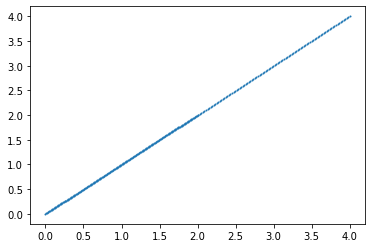

In [24]:
# OLD
'''
zeds_test = CC.ZEDS
print(len(zeds_test))
print(zeds_test[0], zeds_test[-1])

plt.scatter(zeds_test, zeds_test, s=1)
plt.show()
'''

Z_START, Z_STOP, Z_AMOUNT = 0., 4., 199
Z_START_LOG = 1e-1
zeds_pre = np.geomspace(Z_START_LOG, Z_STOP, Z_AMOUNT) - Z_START_LOG
ZEDS = np.insert(zeds_pre, len(zeds_pre), 4.)

z_early = np.linspace(0,2,200)
z_late = np.linspace(2.01,4,100)

zeds_test = np.concatenate((z_early, z_late))
print(len(zeds_test), zeds_test.shape)
print(zeds_test[0], zeds_test[-1])

plt.scatter(zeds_test, zeds_test, s=1)
plt.show()

## Faking double amount of particles to test integral

In [25]:
# Read in neutrino vectors.
Ns = np.arange(CC.NR_OF_NEUTRINOS, dtype=int)  # Nr. of neutrinos
sim = np.array([np.load(f'neutrino_vectors/nu_{Nr+1}.npy') for Nr in Ns])

sim_fake = np.copy(sim)

for i, fake_arr in enumerate(sim_fake):
    np.save(f'neutrino_vectors/nu_{i+1+CC.NR_OF_NEUTRINOS}.npy', fake_arr)

## Shape of derivative for different redshifts

UnitConversionError: Can only apply 'minimum' function to dimensionless quantities when other argument is not a quantity (unless the latter is all zero/infinity/nan)

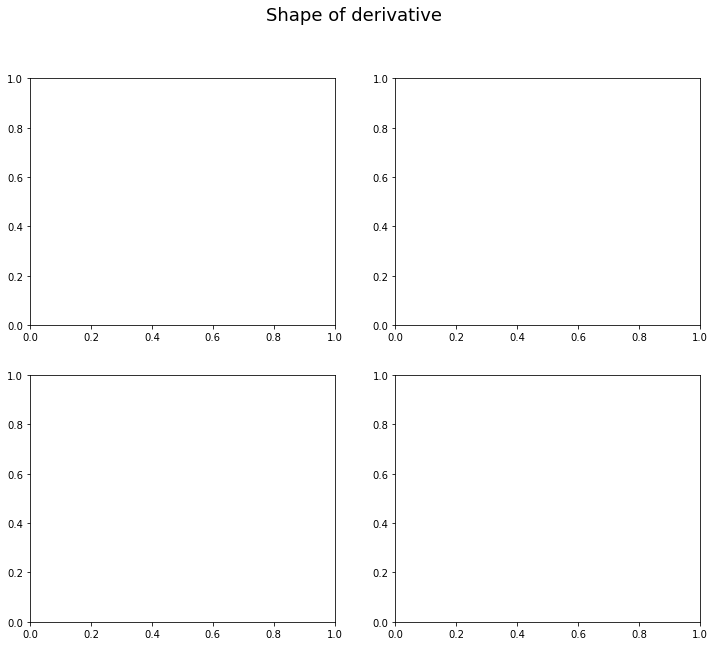

In [26]:
z_arr = np.array([0.1,0.5,2,4.])
r = np.linspace(1,1000,100)*unit.kpc

fig, axs = plt.subplots(2,2, figsize=(12,10))
fig.suptitle('Shape of derivative', fontsize=18)

for j, z in enumerate(z_arr):

    # Compute values dependent on redshift.
    r_vir = fct.R_vir(z, my.Mvir_NFW)
    r_s = r_vir / fct.c_vir(z, my.Mvir_NFW)

    m = np.minimum(r, r_vir)
    M = np.maximum(r, r_vir)

    #! Ratios has to be unitless (e.g. else np.log yields 0.).
    ratio1 = (m/r_s).value
    ratio2 = (r/r_s).value
    ratio3 = (r_vir/M).value

    # Derivative in compact notation with m and M (without x_i).
    prefactor = 4.*np.pi*const.G*my.rho0_NFW*r_s**2./r**2.*(1*unit.kpc)
    term1 = np.log(1.+ratio1) / ratio2
    term2 = ratio3 / (1.+ratio1)
    derivative_vector = (prefactor * (term1 - term2)).to(unit.kpc/unit.s**2.)

    if np.any(derivative_vector.value) < 0.:
        print('neg. derivative!')

    i = 0
    if j in (2,3):
        i = 1
        j -= 2

    axs[i,j].plot(r, derivative_vector)
    axs[i,j].set_title(f'Redshift {z}')
    axs[i,j].set_xlabel('r')
    axs[i,j].set_ylabel('derivative')


## Fermi-Dirac distr. in Ringwald & Wong (2004)

In [ ]:
def Fermi_Dirac_Ringwald_and_Wong(p):
    # Plug into Fermi-Dirac distribution 
    arg_of_exp = (p/my.T_nu_eV).value
    f_of_p = expit(-arg_of_exp)

    return f_of_p

# Original Fermi-Dirac distr.
pOG = np.geomspace(0.01*my.T_nu_eV, 13*my.T_nu_eV, CC.NR_OF_NEUTRINOS)
FDvalsOG = Fermi_Dirac_Ringwald_and_Wong(pOG)
yOG = pOG/my.T_nu_eV.value

plt.loglog(yOG, FDvalsOG, label='Fermi-Dirac')
plt.title('Fermi-Dirac distr. of initial momentum')
plt.ylabel('f(y)')
plt.xlabel('y=p/T_nu')
plt.legend(loc='lower left')
plt.savefig('check_plots/FDdistr_RingwaldWong.pdf')